In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.look_back_tick,
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    num_workers    = params.hparams["NUM_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 3840  (2004-01-02 → 2019-04-04)
 windows       : 1731840  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches= 60, batch_size=64, workers=12, pin_memory=True

--- VAL ---
 calendar days : 751  (2019-04-05 → 2022-03-28)
 windows       : 338701  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=751, batch_size=1, workers=0, pin_memory=True

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=17
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True



In [5]:
# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = params.model_selected.ModelClass(
    n_feats          = len(params.features_cols_tick),                          
    short_units      = params.hparams['SHORT_UNITS'],    
    long_units       = params.hparams['LONG_UNITS'],     
    dropout_short    = params.hparams['DROPOUT_SHORT'],  
    dropout_long     = params.hparams['DROPOUT_LONG'],   
    att_heads        = params.hparams['ATT_HEADS'],
    att_drop         = params.hparams['ATT_DROPOUT'],
    conv_k           = params.hparams['CONV_K'],
    conv_dilation    = params.hparams['CONV_DILATION'],
    # smooth_k         = params.hparams['SMOOTH_K'],
    # smooth_dilation  = params.hparams['SMOOTH_DILATION']
)
model.to(params.device)  

model

ModelClass(
  (conv): Conv1d(17, 17, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (short_lstm): LSTM(17, 64, batch_first=True, bidirectional=True)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.25, inplace=False)
  (short2long): Linear(in_features=128, out_features=128, bias=True)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (do_long): Dropout(p=0.35, inplace=False)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [6]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models_core.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 5e-05
)

In [7]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.405952,  val = 0.409382

Train target stats:
  mean = 0.2836,  var = 0.0844,  std = 0.2905
Train mean‐predictor baseline:
  RMSE_baseline = 0.290471
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



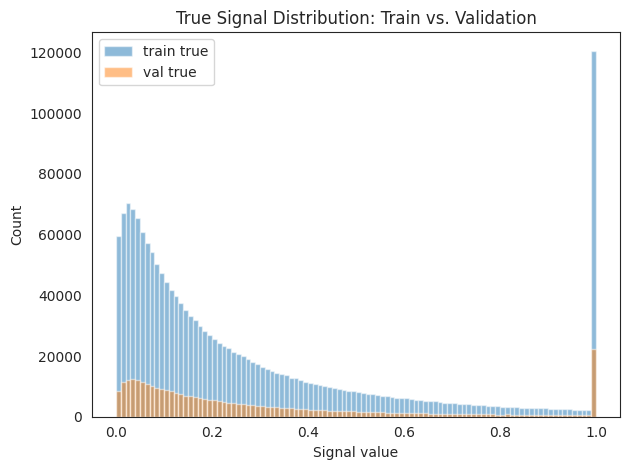

In [8]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.

Using HyperParameters:
 "look_back": 60 {'SHORT_UNITS': 128, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.35, 'ATT_HEADS': 6, 'ATT_DROPOUT': 0.15, 'CONV_K': 3, 'CONV_DILATION': 1, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 1, 'DIFF1_WEIGHT': 1.0, 'DIFF2_WEIGHT': 2, 'SMOOTH_ALPHA': 0.05, 'SMOOTH_BETA': 100, 'SMOOTH_DELTA': 0.02, 'CLS_LOSS_WEIGHT': 0.1, 'LR_EPOCHS_WARMUP': 1, 'INITIAL_LR': 0.0001, 'WEIGHT_DECAY': 5e-05, 'CLIPNORM': 1, 'ETA_MIN': 1e-06, 'T_0': 100, 'T_MULT': 1, 'TRAIN_BATCH': 64, 'VAL_BATCH': 1, 'NUM_WORKERS': 12, 'TRAIN_PREFETCH_FACTOR': 4, 'MAX_EPOCHS': 100, 'EARLY_STOP_PATIENCE': 7, 'PLATEAU_FACTOR': 0.9, 'PLATEAU_PATIENCE': 0, 'MIN_LR': 1e-06, 'PLAT_EPOCHS_WARMUP': 999}


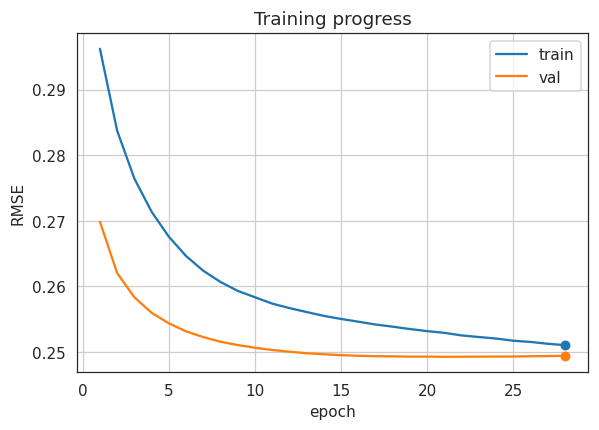

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.29621 MAE=0.22504 R2=-0.03993 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.26985 MAE=0.18373 R2=0.11601 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.28373 MAE=0.21144 R2=0.04585 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.26203 MAE=0.18216 R2=0.16651 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.27643 MAE=0.20740 R2=0.09432 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25835 MAE=0.18248 R2=0.18977 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.27138 MAE=0.20465 R2=0.12713 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25598 MAE=0.18329 R2=0.20455 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.26758 MAE=0.20251 R2=0.15142 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25437 MAE=0.18427 R2=0.21450 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.26464 MAE=0.20072 R2=0.16997 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25315 MAE=0.18536 R2=0.22205 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.26239 MAE=0.19941 R2=0.18403 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25228 MAE=0.18633 R2=0.22740 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.26068 MAE=0.19833 R2=0.19460 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25157 MAE=0.18723 R2=0.23174 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.25932 MAE=0.19745 R2=0.20298 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25106 MAE=0.18795 R2=0.23483 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.25835 MAE=0.19686 R2=0.20892 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25065 MAE=0.18853 R2=0.23731 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.25738 MAE=0.19614 R2=0.21485 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25031 MAE=0.18903 R2=0.23942 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25005_chp.pth
Epoch 012
TRAIN→ RMSE=0.25670 MAE=0.19569 R2=0.21901 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.25005 MAE=0.18940 R2=0.24097 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24981_chp.pth
Epoch 013
TRAIN→ RMSE=0.25610 MAE=0.19528 R2=0.22268 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24981 MAE=0.18975 R2=0.24244 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24966_chp.pth
Epoch 014
TRAIN→ RMSE=0.25551 MAE=0.19483 R2=0.22624 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24966 MAE=0.19009 R2=0.24335 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24953_chp.pth
Epoch 015
TRAIN→ RMSE=0.25504 MAE=0.19451 R2=0.22907 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24953 MAE=0.19037 R2=0.24416 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24943_chp.pth
Epoch 016
TRAIN→ RMSE=0.25462 MAE=0.19417 R2=0.23159 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24943 MAE=0.19061 R2=0.24473 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24936_chp.pth
Epoch 017
TRAIN→ RMSE=0.25419 MAE=0.19385 R2=0.23420 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24936 MAE=0.19080 R2=0.24517 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24934_chp.pth
Epoch 018
TRAIN→ RMSE=0.25386 MAE=0.19358 R2=0.23617 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24934 MAE=0.19104 R2=0.24531 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24930_chp.pth
Epoch 019
TRAIN→ RMSE=0.25350 MAE=0.19333 R2=0.23834 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24930 MAE=0.19127 R2=0.24553 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.25319 MAE=0.19307 R2=0.24023 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24930 MAE=0.19144 R2=0.24552 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

🔖 Saved folder‐best checkpoint (_chp): AAPL_0.24927_chp.pth
Epoch 021
TRAIN→ RMSE=0.25292 MAE=0.19289 R2=0.24182 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24927 MAE=0.19158 R2=0.24569 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.25253 MAE=0.19254 R2=0.24418 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24928 MAE=0.19170 R2=0.24564 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.25229 MAE=0.19235 R2=0.24562 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24930 MAE=0.19185 R2=0.24556 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.25205 MAE=0.19220 R2=0.24702 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24931 MAE=0.19195 R2=0.24549 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.25173 MAE=0.19189 R2=0.24898 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24932 MAE=0.19203 R2=0.24543 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.25154 MAE=0.19176 R2=0.25012 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24936 MAE=0.19211 R2=0.24519 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.25126 MAE=0.19153 R2=0.25176 | Acc=0.72337 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000
VALID→ RMSE=0.24938 MAE=0.19222 R2=0.24503 | Acc=0.71270 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.50000 | T_ACC=0.33333 T_P=0.00004 T_R=0.33333 T_F1=0.00007 T_AUC=0.50000


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 28
✅ Final‐best model saved: AAPL_0.24927_fin.pth


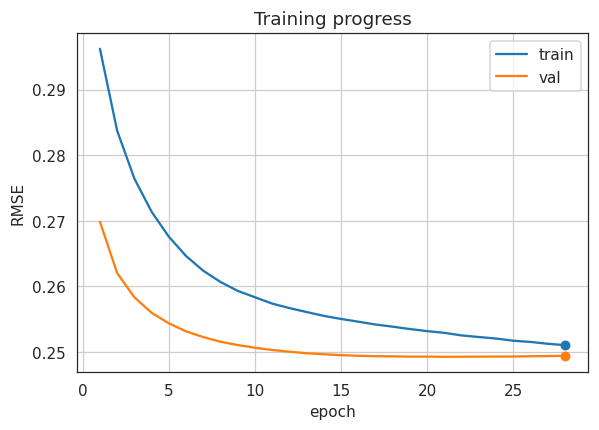

In [9]:
importlib.reload(params.model_selected) #############

# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n "look_back":', params.look_back_tick, params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = params.model_selected.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device,
    cls_loss_weight     = params.hparams['CLS_LOSS_WEIGHT'],
    smooth_alpha        = params.hparams['SMOOTH_ALPHA'],
    smooth_beta         = params.hparams['SMOOTH_BETA'],
    smooth_delta        = params.hparams['SMOOTH_DELTA'],
    diff1_weight        = params.hparams['DIFF1_WEIGHT'],
    diff2_weight        = params.hparams['DIFF2_WEIGHT'],
)


In [10]:
# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")



Champion validation RMSE = 0.249273
Improvement over zero‐baseline =  39.1%
Improvement over mean‐baseline =  13.1%


In [11]:
print(list(model.named_parameters()))

[('conv.weight', Parameter containing:
tensor([[[ 6.7904e-02, -7.6095e-02,  6.3943e-02],
         [ 1.1004e-01,  3.4873e-02, -2.2121e-02],
         [ 5.0256e-02,  1.2964e-01, -5.8697e-03],
         [-3.5813e-02, -7.6563e-02,  8.3840e-02],
         [ 6.4093e-02,  2.2862e-02, -9.7935e-02],
         [-1.1100e-01,  8.2527e-02,  1.1221e-01],
         [ 1.2580e-01, -3.1666e-02, -8.5748e-02],
         [ 1.4179e-01, -6.9564e-03, -1.4956e-01],
         [ 5.9734e-02, -3.0292e-02, -7.8979e-02],
         [ 7.4548e-02,  5.6852e-02, -8.4013e-02],
         [ 1.9071e-02,  1.1266e-01,  6.8859e-02],
         [-5.7999e-02, -3.7994e-02, -9.1588e-02],
         [ 1.3064e-01,  1.2454e-01,  4.3358e-02],
         [-1.3218e-01,  6.7533e-02, -3.6021e-02],
         [ 9.6856e-02, -7.0432e-02, -5.4351e-02],
         [-6.4015e-02, -1.8121e-02,  1.1994e-01],
         [ 1.4834e-01, -9.0579e-02, -1.0978e-01]],

        [[ 9.4921e-06, -9.8578e-03, -1.3864e-01],
         [ 6.0491e-02, -1.3023e-01,  8.1452e-02],
         